In [2]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

from quickstats.plots import UpperLimit1DPlot
from quickstats.plots import UpperLimit2DPlot
from quickstats.plots import Likelihood2DPlot, UpperLimit3DPlot
from quickstats.utils.common_utils import combine_dict
from quickstats.maths.interpolation import get_intersections

%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
if "hh_combination_fw_path" not in os.environ:
    os.environ['hh_combination_fw_path'] = os.path.abspath("../../")
outdir_xsection = os.environ['hh_combination_fw_path']+'/tutorials/HHH2022/outputs_HHH2022_20220520_noSgHparam/'
# outdir_xsection = os.environ['hh_combination_fw_path']+'/tutorials/HHH2022/outputs_HHH2022_20220520_with_BR_decorrelation/'
outdir_likelihood = os.environ['hh_combination_fw_path']+'/tutorials/HHH2022/outputs_HHH2022_20220520_with_BR_decorrelation/'


In [47]:
resonant_type = 'nonres'
combine_tag = 'A-bbbb_bbtautau_bbyy-fullcorr'
def remove_list(data):
    for k, v in data.items():
        for p,v_ in v.items():
            data[k][p] = v_[0]
    return data
channel_label_map = {
    'bbbb': r"$\mathit{b\bar{b}b\bar{b}}$",
    'bbtautau': r"$\mathit{b\bar{b}\tau^+\tau^-}$",
    'bbyy': r"$\mathit{b\bar{b}\gamma\gamma}$",
    'combined': r"Combined",
}
# channel_text = {
#     'combined': r'$m_H=125.09$ GeV//$\mathrm{HH\rightarrow b\bar{b}\tau^+\tau^-} + b\bar{b}\gamma\gamma + b\bar{b}b\bar{b}$',
#     'bbbb': r'$m_H=125.09$ GeV//$\mathrm{HH\rightarrow b\bar{b}b\bar{b}}$',
#     'bbyy': r'$m_H=125.09$ GeV//$\mathrm{HH\rightarrow b\bar{b}\gamma\gamma}$',
#     'bbtautau': r'$m_H=125.09$ GeV//$\mathrm{HH\rightarrow b\bar{b}\tau^+\tau^-}$',
# }
channel_text = {
    'combined': r'$\mathit{HH\rightarrow b\bar{b}\tau^+\tau^- + b\bar{b}\gamma\gamma + b\bar{b}b\bar{b}}$',
    'bbbb': r'$\mathit{HH\rightarrow b\bar{b}b\bar{b}}$',
    'bbyy': r'$\mathit{HH\rightarrow b\bar{b}\gamma\gamma}$',
    'bbtautau': r'$\mathit{HH\rightarrow b\bar{b}\tau^+\tau^-}$',
}
statuses = ['int', 'prelim', 'final']

In [48]:
31.02+1.723, 31.05+1.726

(32.743, 32.776)

## 1. SM Limit Plot

In [6]:
def get_limit_data(json_name=None):
    scale_factor = 1
    sm_limit_df = {}
    channels = ['bbtautau', 'bbyy', 'bbbb']
    data = {}
    for channel in channels + ['combined']:
        if json_name is None:
            limit_path = os.path.join(outdir_xsection, 'limits', resonant_type, channel, combine_tag if channel == 'combined' else '', 'limits.json')
        else:
            limit_path = os.path.join(outdir_xsection, 'limits', resonant_type, channel, json_name)

        print(limit_path)
        data[channel] = json.load(open(limit_path))
    print(data)
    data_dict = remove_list(data)
    sm_limit_df = pd.DataFrame(data_dict) * scale_factor
    return sm_limit_df

def append_limit_SM(sm_limit_df):
    third_limit = {}
    channels = ['bbtautau', 'bbyy', 'bbbb']
    for channel in channels + ['combined']:
        limit_path = os.path.join(outdir_xsection, 'limits', resonant_type, channel, 'limits_asimovData_1_NP_Profile.json')
        third_limit[channel] = json.load(open(limit_path))['obs']
    sm_limit_df.loc['third'] = third_limit
    return sm_limit_df

    
def plot_SM(sm_limit_df, third = False, status='int'):
    plotting_order = ['combined', 'bbbb', 'bbtautau', 'bbyy' ]
    sm_limit_df = sm_limit_df[plotting_order]
    analysis_label_options = {'fontsize':30, 'energy': '13 TeV', 
                              'status': status,
                                      'lumi': '126—139 fb$^{-1}$',
                                      # https://twiki.cern.ch/twiki/bin/view/LHCPhysics/LHCHWGHH?redirectedfrom=LHCPhysics.LHCHXSWGHH#Latest_recommendations_for_gluon
#                                       'extra_text': r'$m_H=125.09$ GeV//$\sigma_{ggF+VBF}^{SM}=32.7$ fb', # 125.09GeV: 31.02+1.723=32.743;  125GeV: 31.05+1.726=32.776
                                      'extra_text': r'$\sigma_{ggF+VBF}^{SM} (\mathit{HH})=32.7$ fb', # 125.09GeV: 31.02+1.723=32.743;  125GeV: 31.05+1.726=32.776
                                      }
    styles = {
        'figure':{
        },
        'axis':{
            'tick_bothsides': False,
            'major_length': 12,
            },
        'legend':{
            'loc': 'upper right',
            },
    }
    config = {
        'top_margin': 4 if third else 2.7,
    }

    plotter = UpperLimit1DPlot(sm_limit_df, channel_label_map, line_below=["bbbb"], labels={'expected': 'Expected limit\n'+r'($\mathit{\mu_{HH}} = 0$ hypothesis)', 'third': 'Expected limit\n(SM hypothesis)'} if third else {'expected': 'Expected limit\n'+r'($\mathit{\mu_{HH}} = 0$ hypothesis)'},
                               analysis_label_options=analysis_label_options, styles=styles, config=config)
    ax = plotter.draw(logx=False, xlabel=r"95% CL upper limit on $\mathit{HH}$ signal strength $\mathit{\mu_{HH}}$", draw_observed=True, draw_stat=False, sig_fig=1,
                     draw_third_column = 'Exp.\n(SM)' if third else None,
                     )
    ax.set_xlim([0, 30])
    os.makedirs(os.path.join(outdir_xsection, f'figures/SM/{status}/'), exist_ok=True)
    filename = os.path.join(outdir_xsection, f'figures/SM/{status}/', f"SM_limit{'withSM' if third else ''}_{status}.pdf")
    plt.savefig(filename, bbox_inches="tight")
    print('Save to', filename)


### 1.2 Plotting

In [15]:
sm_limit_df = get_limit_data()


/afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220520_noSgHparam/limits/nonres/bbtautau/limits.json
/afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220520_noSgHparam/limits/nonres/bbyy/limits.json
/afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220520_noSgHparam/limits/nonres/bbbb/limits.json
/afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220520_noSgHparam/limits/nonres/combined/A-bbbb_bbtautau_bbyy-fullcorr/limits.json
{'bbtautau': {'mass': [0], '0': [3.8796341705855566], '2': [9.42413644716919], '1': [5.902281704796226], '-1': [2.7954912460396018], '-2': [2.0822996798855606], 'obs': [4.700348833168281], 'inj': [0]}, 'bbyy': {'mass': [0], '0': [5.711759124736776], '2': [14.211670665353362], '1': [8.79603389751452], '-1': [4.115638725359132], '-2': [3.0656

In [100]:
# sm_limit_df2 = get_limit_data('limits_asimovData_1_NP_Profile.json')

# sm_limit_df,

/afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220520_noSgHparam/limits/nonres/bbtautau/limits.json
/afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220520_noSgHparam/limits/nonres/bbyy/limits.json
/afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220520_noSgHparam/limits/nonres/bbbb/limits.json
/afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220520_noSgHparam/limits/nonres/combined/A-bbbb_bbtautau_bbyy-fullcorr/limits.json
{'bbtautau': {'mass': [0], '0': [3.8796341705855566], '2': [9.42413644716919], '1': [5.902281704796226], '-1': [2.7954912460396018], '-2': [2.0822996798855606], 'obs': [4.700348833168281], 'inj': [0]}, 'bbyy': {'mass': [0], '0': [5.711759124736776], '2': [14.211670665353362], '1': [8.79603389751452], '-1': [4.115638725359132], '-2': [3.0656

<Figure size 432x288 with 0 Axes>

<Figure size 799.992x743.976 with 0 Axes>

<Figure size 799.992x743.976 with 0 Axes>

<Figure size 799.992x743.976 with 0 Axes>

<Figure size 799.992x743.976 with 0 Axes>

<Figure size 799.992x743.976 with 0 Axes>

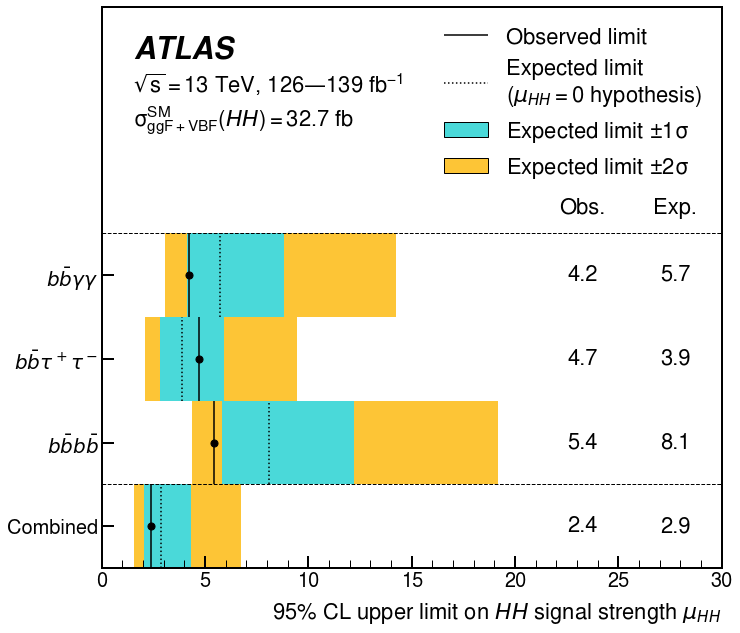

In [101]:
sm_limit_df = get_limit_data()
# sm_limit_df2 = get_limit_data('limits_asimovData_1_NP_Profile.json')
sm_limit_df = append_limit_SM(sm_limit_df)
for status in statuses:
    plot_SM(sm_limit_df, third=True, status=status)
    plot_SM(sm_limit_df, third=False, status=status)
#     plot_SM(sm_limit_df2, third=False, status=status)


## Cross section limit

In [102]:
# exp, obs (SM * limit (fb))
32.743 * 2.60595284341142, 32.743 * 2.23216499667234

(85.32671395182014, 73.08777848604242)

## 2. Cross section Scan - kl

In [16]:
def get_xsection_scan_limit(poi = 'klambda'):
    kl_param_limit_df = {}
    POI = {
        'klambda': 'klambda',
        'k2v': 'k2V',
    }
    channels = ['bbbb', 'bbtautau', 'bbyy']
    data = {}
    for channel in channels+['combined']:
        limit_path = os.path.join(outdir_xsection, 'xsection_scan', channel, poi, 'limits.json')
        data[channel] = json.load(open(limit_path))
        
    for channel in data:
        df = pd.DataFrame(data[channel]).set_index([POI[poi]])
        kl_param_limit_df[channel] = df

    return kl_param_limit_df
 

def get_intersections2(lambdas, n_exp, lambdas_th, n_th):
    # get the intersection between expected and theory prediction
    
    # interpolate expected limit with same number of datapoints as used in theory prediction
    interpolated_limit = np.interp(lambdas_th, lambdas, n_exp) 

    #limitm1 = n*np.array(limit_bands[0]) - 1
    limitm1 = interpolated_limit - n_th 
    idx = np.argwhere(np.diff(np.sign(limitm1))).flatten() # determines what index intersection points are at 

    #linear interpolation to get exact intercepts: x = x1 + (x2-x1)/(y2-y1) * (y-y1)
    #y = 0 -> x = x1 - (x2-x1)/(y2-y1) * y1
    intersections = [lambdas_th[x] - (lambdas_th[x+1] - lambdas_th[x])/(limitm1[x+1] - limitm1[x]) * limitm1[x] for x in idx]
    return intersections



In [17]:
def theory_cross_section_kl(kl, mH, production, s=13):
    sm_xsec_vbf = {
        '125.09': 1.723,
        '125': 1.726,
    }
    sm_xsec_ggF = {
        '125.09': 31.02,
        '125': 31.05,
    }
    SCALE_GGF = sm_xsec_ggF[str(mH)]/31.0358  #correct to xs at mH
    SCALE_VBF = sm_xsec_vbf[str(mH)]/(4.581-4.245+1.359)

    kl = np.array(kl)
    
    # Calculate ggF theory curve
    if production.lower() != 'vbf':
        #https://twiki.cern.ch/twiki/bin/view/LHCPhysics/LHCHWGHH?redirectedfrom=LHCPhysics.LHCHXSWGHH#Latest_recommendations_for_gluon
        xs_ggF = (70.3874-50.4111*kl+11.0595*np.square(kl))*SCALE_GGF #XS in fb
        xs_ggF_up = xs_ggF * np.sqrt(np.square((np.maximum(76.6075 - 56.4818*kl + 12.635*np.square(kl), 75.4617 - 56.3164*kl + 12.7135*np.square(kl)) * SCALE_GGF / xs_ggF - 1)) + 0.03**2)
        xs_ggF_down = xs_ggF * np.sqrt(np.square((np.minimum(57.6809 - 42.9905*kl + 9.58474*np.square(kl), 58.3769 - 43.9657*kl + 9.87094*np.square(kl)) * SCALE_GGF / xs_ggF - 1)) + 0.03**2)
    
    # Calculate VBF theory curve
    if production.lower() != 'ggf':
        #https://indico.cern.ch/event/995807/contributions/4184798/attachments/2175756/3683303/VBFXSec.pdf
        xs_VBF = (4.581-4.245*kl+1.359*np.square(kl))*SCALE_VBF
        xs_VBF_up = xs_VBF * np.sqrt(0.0003**2 + 0.021**2)
        xs_VBF_down = xs_VBF * np.sqrt(0.0004**2 + 0.021**2)
    
    # Calculate ggF+VBF theory curve
    if production.lower() == 'all':
        xs_HH = xs_ggF + xs_VBF
        xs_HH_up = np.sqrt(np.square(xs_ggF_up) + np.square(xs_VBF_up))
        xs_HH_down = np.sqrt(np.square(xs_ggF_down) + np.square(xs_VBF_down))

    if s == 14:
        xs_HH = xs_ggF * 1.18 + xs_VBF * 1.19
        xs_HH_up /= 2
        xs_HH_down /= 2
        assert(production.lower() == 'all'), 'for ggF or VBF only projection, please revisit factors on the theory error.'
        
    if production.lower() == 'ggf':
        return xs_ggF, xs_ggF+xs_ggF_up, xs_ggF-xs_ggF_down
    elif production.lower() == 'vbf':
        return xs_VBF, xs_VBF+xs_VBF_up, xs_VBF-xs_VBF_down
    elif production.lower() == 'all':
        return xs_HH, xs_HH+xs_HH_up, xs_HH-xs_HH_down
    else:
        assert(0), f'production {production} is not implemented'



In [18]:
# from quickstats.maths.interpolation import get_intersections

def plot_individual(channel, ax, plotter, kl_param_limit_df, linewidth=3):
    from copy import deepcopy
    color_pallete = {
        'bbbb': 'b',
        'bbtautau': "#008F00",
        'bbyy': "#9A0EEA",
        'combined': 'k',
    }
    handles_map = {}
    for subchannel in kl_param_limit_df:
        data = kl_param_limit_df[subchannel]
        indices = data.index.astype(float).values
        exp_limits = data['0'].values * plotter.scale_factor
        obs_limits = data['obs'].values * plotter.scale_factor
        if subchannel == channel:
            alpha = 0
        else:
            alpha = 1
        ax.semilogy(indices, exp_limits, color=color_pallete[subchannel], linestyle='--', alpha=alpha, label=channel_label_map[subchannel], linewidth=linewidth)
        handle_channels = ax.semilogy(indices, obs_limits, color=color_pallete[subchannel], linestyle='-', linewidth=linewidth, alpha=1, label=channel_label_map[subchannel])
        handles_map[subchannel] = handle_channels[0]

    def update_legend_handles(handles):
        import matplotlib
        legend_data = {}

        for key in handles:
            handle = handles[key]
            if isinstance(handle, matplotlib.container.Container):
                label = handle.get_label()
            elif isinstance(handle, (tuple, list)):
                label = handle[0].get_label()
            else:
                label = handle.get_label()
            if label and not label.startswith('_'):
                legend_data[key] = {
                    'handle': handle,
                    'label': label
                }
            else:
                raise RuntimeError(f"the handle {handle} does not have an associated label")
        return legend_data

    def get_legend_handles_labels(legend_data):
        handles = []
        labels = []

        for key in ['bbyy', 'bbtautau', 'bbbb', 'combined']:
            if key in legend_data:
                handle = legend_data[key]['handle']
                label = legend_data[key]['label']
                handles.append(handle)
                labels.append(label)
        return handles, labels

    legend_data = update_legend_handles(handles_map)
    handles_sec, labels_sec = get_legend_handles_labels(legend_data)

    ax.add_artist(ax.get_legend())
    sec_style = deepcopy(plotter.styles['legend'])
    sec_style['loc'] = (0.7, 0.02)
    ax.legend(handles_sec, labels_sec, **sec_style)


def plot_xsection_scan_kl(kl_param_limit_df, channel, mH, production, poi='klambda', xmin=None, xmax=None, ymin=None, ymax=None, add_individual=True, disable_error=False, status='int'):

    analysis_label_options = {
        'status': status,
        'loc': (0.05, 0.95),
        'energy': '13 TeV',
        'lumi': r'126—139 fb$^{-1}$',
        'fontsize': 30,
        'extra_text':channel_text[channel] # + '//Parameterised workspace'    
    }
    styles = {
        'legend':{
            'loc': (0.58, 0.58) if not disable_error else (0.58, 0.73),
            'fontsize': 17
        },
        'axis':{
            'tick_bothsides': True,
            'major_length': 12,
            'labelsize': 25,
        },
        'xlabel': {
            'fontsize': 30,
        },
        'ylabel': {
            'fontsize': 30,
        },
    }
    
    poi_name = {
        'klambda': r'$\kappa_\lambda$',
        'k2v': r'$\kappa_{2V}$',
        'kv': r'$\kappa_{V}$',
    }
    ylabel = {
        'ggf': r"$\sigma_{ggF}(\mathit{HH})$ [fb]",
        'vbf': r"$\sigma_{VBF}(\mathit{HH})$ [fb]",
        'all': r"$\sigma_{ggF+VBF}(\mathit{HH})$ [fb]",
    }
    
    klambda_values =  kl_param_limit_df['bbyy'].index.astype(float).values
    theory_xs_values, theory_xs_upper, theory_xs_lower = theory_cross_section_kl(klambda_values, mH, production)

    klambda_values_dense = np.linspace(min(klambda_values), max(klambda_values), 200000) 
    theory_xs_values_dense, theory_xs_upper_dense, theory_xs_lower_dense = theory_cross_section_kl(klambda_values_dense, mH, production)

    plotter = UpperLimit2DPlot(kl_param_limit_df[channel], labels={'expected': 'Expected limit (95% CL)\n'+r'($\mathit{\mu_{HH}} = 0$ hypothesis)'},
                               scale_factor=theory_xs_values, styles=styles,
                               analysis_label_options=analysis_label_options)
    plotter.add_curve(klambda_values_dense, theory_xs_values_dense, theory_xs_lower_dense, theory_xs_upper_dense, 
                      label="Theory prediction")
    plotter.add_highlight(1, theory_cross_section_kl(1, mH, production)[0],
                          label="SM prediction")
    xmin = kl_param_limit_df[channel].index.min() if not xmin else xmin
    xmax = kl_param_limit_df[channel].index.max() if not xmax else xmax
    ylim = {
        'klambda': [(10 if not ymin else ymin), (7e4 if not ymax else ymax)],
        'k2v': [1, 1e4],
    }
    ax = plotter.draw(xlabel=poi_name[poi], ylabel=ylabel[production.lower()],
                 draw_observed=True, log=True, ylim=ylim[poi], xlim=[xmin, xmax], observed_marker='', linewidth=4, draw_errorband=not disable_error)

    intersections = get_intersections2(klambda_values, 
                                      theory_xs_values*kl_param_limit_df[channel]['0'],
                                      klambda_values_dense, theory_xs_values_dense)

    intersections_obs = get_intersections2(klambda_values, 
                                      theory_xs_values*kl_param_limit_df[channel]['obs'],
                                      klambda_values_dense, theory_xs_values_dense)
# #     ax.annotate(r'Expected: '+poi_name[poi]+'$ \in [%.1f, %.1f]$' %(intersections[0], intersections[1]), 
# #                 (0.05, 0.08), xycoords = 'axes fraction', fontsize = 18)
# #     ax.annotate(r'Observed: '+poi_name[poi]+'$ \in [%.1f, %.1f]$' %(intersections_obs[0], intersections_obs[1]), 
# #                 (0.05, 0.15), xycoords = 'axes fraction', fontsize = 18)
    print(channel, 'obs', intersections_obs[0], intersections_obs[1])
    print(channel, 'exp', intersections[0], intersections[1])
    
    # Add individual curves on top
    if channel == 'combined' and add_individual:
        plot_individual(channel, ax, plotter, kl_param_limit_df)

    save_foler = outdir_xsection+f"/figures/xsection_scan/{status}/"
    os.makedirs(save_foler, exist_ok=True)
    suffix = ''
    if add_individual:
        suffix += '_withindiv'
    if disable_error:
        suffix += '_noError'
    plt.savefig(save_foler+f"{poi}_limit_parameterised_ws_{channel}{suffix}_{status}.pdf", bbox_inches="tight")
    print("save to", save_foler)
    

In [19]:
poi = 'klambda'

kl_param_limit_df = get_xsection_scan_limit(poi = poi)
kl_param_limit_df.keys()

dict_keys(['bbbb', 'bbtautau', 'bbyy', 'combined'])

combined obs -0.5830983205900682 6.66066301444844
combined exp -0.9908788724934876 7.064538129174959
save to /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220520_noSgHparam//figures/xsection_scan/int/
combined obs -0.5830983205900682 6.66066301444844
combined exp -0.9908788724934876 7.064538129174959
save to /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220520_noSgHparam//figures/xsection_scan/int/
combined obs -0.5830983205900682 6.66066301444844
combined exp -0.9908788724934876 7.064538129174959
save to /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220520_noSgHparam//figures/xsection_scan/prelim/
combined obs -0.5830983205900682 6.66066301444844
combined exp -0.9908788724934876 7.064538129174959
save to /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_2

<Figure size 432x288 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

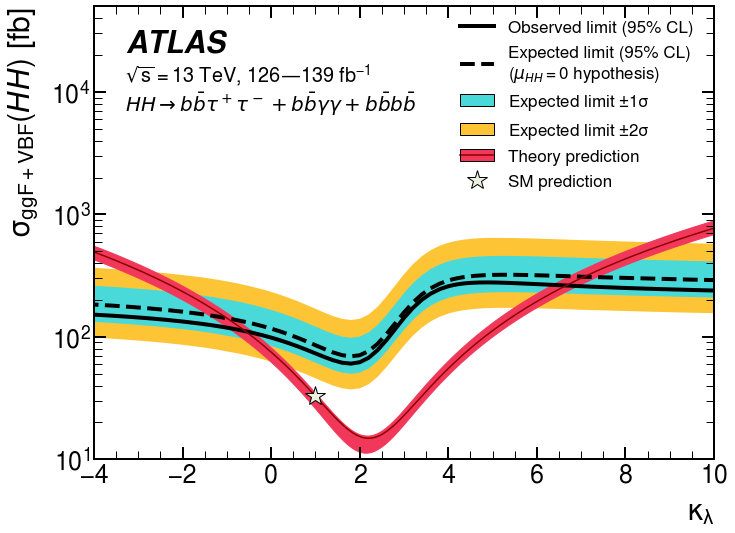

In [20]:
mH = "125.09"
production = 'all'

# plot_xsection_scan_kl(kl_param_limit_df, 'bbbb', mH, production, poi)
# plot_xsection_scan_kl(kl_param_limit_df, 'bbtautau', mH, production, poi)
# plot_xsection_scan_kl(kl_param_limit_df, 'bbyy', mH, production, poi)

for status in statuses:
    plot_xsection_scan_kl(kl_param_limit_df, 'combined', mH, production, poi, xmin=-10, xmax=15, status=status)
    plot_xsection_scan_kl(kl_param_limit_df, 'combined', mH, production, poi, xmin=-4, xmax=10, ymax=5e4, add_individual=False, status=status)
    # plot_xsection_scan_kl(kl_param_limit_df, 'combined', mH, production, poi, xmin=-10, xmax=15, disable_error=True, status=status)


## 3. Cross section Scan - k2v

In [21]:
import sympy
def get_theory_combination_function(mH):
    # https://twiki.cern.ch/twiki/bin/view/LHCPhysics/LHCHWGHH?redirectedfrom=LHCPhysics.LHCHXSWGHH
    sm_N3LO_xsec = {
        '125.09': 1.723,
        '125': 1.726,
    }[str(mH)]

    # Below xsec values are from AMI as of 9 December 2020, for tag: e8263_e7400_s3126_r10201
    basis_xsec_list = [
        # ([k2v, kl, kv], xsec)
        ([1, 1, 1], 1.18),
        ([1.5, 1, 1], 2.30),
        ([2, 1, 1], 9.97),
        ([1, 0, 1], 3.17),
        ([1, 10, 1], 67.4),
        ([1, 1, 1.5], 45.4),
    ]
    xsec_correction = sm_N3LO_xsec / basis_xsec_list[0][1]

    theory_basis_list, xsec_list = zip(*basis_xsec_list)
    corrected_xsecs = [xsec * xsec_correction for xsec in xsec_list]

    theory_amplitude_function = get_amplitude_function(
        theory_basis_list, full_amplitude=True
    )
    theory_combination_function = lambda couplings: theory_amplitude_function(
        *couplings, *corrected_xsecs
    )
    return theory_combination_function

def get_amplitude_function(basis_list, full_amplitude=False, diagram_term_list=None):
    basis_states = [[sympy.Rational(param) for param in basis] for basis in basis_list]

    _k2v = sympy.Symbol("\kappa_{2V}")
    _kl = sympy.Symbol("\kappa_{\lambda}")
    _kv = sympy.Symbol("\kappa_{V}")

    if diagram_term_list is None:
        diagram_term_list = [
            lambda k2v, kl, kv: kv ** 2 * kl ** 2,
            lambda k2v, kl, kv: kv ** 4,
            lambda k2v, kl, kv: k2v ** 2,
            lambda k2v, kl, kv: kv ** 3 * kl,
            lambda k2v, kl, kv: k2v * kl * kv,
            lambda k2v, kl, kv: kv ** 2 * k2v,
        ]

    combination_matrix = sympy.Matrix(
        [[term(*base) for term in diagram_term_list] for base in basis_states]
    )
    inversion = combination_matrix.inv()
    term_vector = sympy.Matrix([[term(_k2v, _kl, _kv)] for term in diagram_term_list])
    if full_amplitude:
        amplitudes = sympy.Matrix(
            [sympy.Symbol(f"A{n}") for n in range(len(diagram_term_list))]
        )
        final_amplitude = (term_vector.T * inversion * amplitudes)[0]
        amplitude_function = sympy.lambdify(
            [_k2v, _kl, _kv] + [*amplitudes], final_amplitude, "numpy"
        )
        return amplitude_function

    else:
        final_weight = term_vector.T * inversion
        reweight_vector = sympy.lambdify([_k2v, _kl, _kv], final_weight, "numpy")
        return reweight_vector

In [24]:
def plot_xsection_scan_k2v(k2v_param_limit_df, channel, mH, production='vbf', poi='k2v', xmin=-2, xmax=4, add_individual=True, disable_error=False, status="int"):
    kl_value, kv_value = 1, 1
    mod_vals_dense = k2v_param_limit_df['bbyy'].index.astype(float).values

    theory_cross_section_k2v = get_theory_combination_function(mH)

    k2v_values =  k2v_param_limit_df['bbyy'].index.astype(float).values
    theory_xs_values = theory_cross_section_k2v((np.array(k2v_values), kl_value, kv_value))

    k2v_values_dense = np.linspace(min(k2v_values), max(k2v_values), 200000) 
    theory_xs_values_dense = theory_cross_section_k2v((np.array(k2v_values_dense), kl_value, kv_value))
    
    if production.lower() == 'vbf':
        pass # not include ggf xs
    elif production.lower() == 'all':
        # For k2v variations, take ggF xs as SM ggF xs
        theory_xs_values_ggf, theory_xs_upper_ggf, theory_xs_lower_ggf = theory_cross_section_kl(kl_value, mH, 'ggf')
        theory_xs_values += np.repeat(theory_xs_values_ggf, len(k2v_values))
        theory_xs_values_ggf_dense, theory_xs_upper_ggf_dense, theory_xs_lower_ggf_dense = theory_cross_section_kl(kl_value, mH, 'ggf')
        theory_xs_values_dense += np.repeat(theory_xs_values_ggf_dense, len(k2v_values_dense))
    else:
        assert(0), f'production {production} is not implemented'

        
    analysis_label_options = {
        'status': status,
        'loc': (0.05, 0.95),
        'energy': '13 TeV',
        'lumi': r'126—139 fb$^{-1}$',
        'fontsize': 30,
        'extra_text':channel_text[channel] # + '//Parameterised workspace'    
    }
    styles = {
        'legend':{
            'loc': (0.58, 0.58),
            'fontsize': 17
        },
        'axis':{
            'tick_bothsides': True,
            'major_length': 12,
            'labelsize': 25,
        },
        'xlabel': {
            'fontsize': 30,
        },
        'ylabel': {
            'fontsize': 30,
        },
    }
    
    poi_name = {
        'klambda': r'$\kappa_\lambda$',
        'k2v': r'$\kappa_{2V}$',
    }
    ylabel = {
        'vbf': r"$\sigma_{VBF}(\mathit{HH})$ [fb]",
        'all': r"$\sigma_{ggF+VBF}(\mathit{HH})$ [fb]",
    }
    
    plotter = UpperLimit2DPlot(k2v_param_limit_df[channel],  labels={'expected': 'Expected limit (95% CL)\n'+r'($\mathit{\mu_{HH}} = 0$ hypothesis)'},
                               scale_factor=theory_xs_values, styles=styles,
                               analysis_label_options=analysis_label_options)
#     plotter.add_curve(k2v_values_dense, theory_xs_values_dense, theory_xs_lower_dense, theory_xs_upper_dense, 
    plotter.add_curve(k2v_values_dense, theory_xs_values_dense, theory_xs_values_dense, theory_xs_values_dense, 
                      label="Theory prediction")
    SM_xs = theory_cross_section_k2v((1, kl_value, kv_value))
    if production.lower() == 'all':
        SM_xs += theory_cross_section_kl(1, mH, 'ggf')[0]
    plotter.add_highlight(1, SM_xs, label="SM prediction")
    xmin = k2v_param_limit_df[channel].index.min() if not xmin else xmin
    xmax = k2v_param_limit_df[channel].index.max() if not xmax else xmax
    ylim = {
        'klambda': [10, 1e5],
        'k2v': [0.7, 7e3],
    }
    ax = plotter.draw(xlabel=poi_name[poi], ylabel=ylabel[production.lower()],
                 draw_observed=True, log=True, ylim=ylim[poi], xlim=[xmin, xmax], observed_marker='', linewidth=4, draw_errorband=not disable_error)
#     intersections = get_intersections2(k2v_values, 
#                                       theory_xs_values*k2v_param_limit_df[channel]['0'],
#                                       k2v_values_dense, theory_xs_values_dense)

#     intersections_obs = get_intersections2(k2v_values, 
#                                       theory_xs_values*k2v_param_limit_df[channel]['obs'],
#                                       k2v_values_dense, theory_xs_values_dense)
#     ax.annotate(r'Expected: '+poi_name[poi]+'$ \in [%.1f, %.1f]$' %(intersections[0], intersections[1]), 
#                 (0.05, 0.08), xycoords = 'axes fraction', fontsize = 18)
#     ax.annotate(r'Observed: '+poi_name[poi]+'$ \in [%.1f, %.1f]$' %(intersections_obs[0], intersections_obs[1]), 
#                 (0.05, 0.15), xycoords = 'axes fraction', fontsize = 18)
#     print(channel, 'obs', intersections_obs[0], intersections_obs[1])
#     print(channel, 'exp', intersections[0], intersections[1])
    
    # Add individual curves on top
    if channel == 'combined' and add_individual:
        plot_individual(channel, ax, plotter, k2v_param_limit_df)

    suffix = ''
    if add_individual:
        suffix += '_withindiv'
    if disable_error:
        suffix += '_noError'
    save_foler = outdir_xsection+f"/figures/xsection_scan/{status}/"
    os.makedirs(save_foler, exist_ok=True)
    filename = save_foler+f"{poi}_limit_parameterised_ws_{channel}{suffix}_{status}.pdf"
    plt.savefig(filename, bbox_inches="tight")
    print("save to", filename)


In [25]:
poi = 'k2v'
production = 'vbf'
k2v_param_limit_df = get_xsection_scan_limit(poi = poi)

save to /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220520_noSgHparam//figures/xsection_scan/int/k2v_limit_parameterised_ws_combined_withindiv_int.pdf
save to /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220520_noSgHparam//figures/xsection_scan/int/k2v_limit_parameterised_ws_combined_int.pdf
save to /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220520_noSgHparam//figures/xsection_scan/prelim/k2v_limit_parameterised_ws_combined_withindiv_prelim.pdf
save to /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220520_noSgHparam//figures/xsection_scan/prelim/k2v_limit_parameterised_ws_combined_prelim.pdf
save to /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220520_noSgHparam//figures/xsection_scan/f

<Figure size 432x288 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

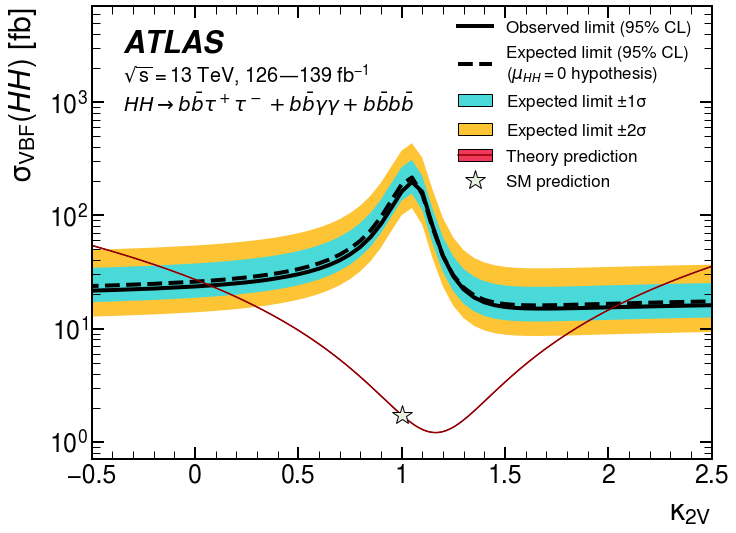

In [26]:
# theory_line = plot_xsection_scan_k2v(k2v_param_limit_df, 'bbyy', mH, production, poi)
# theory_line = plot_xsection_scan_k2v(k2v_param_limit_df, 'bbtautau', mH, production, poi)
# theory_line = plot_xsection_scan_k2v(k2v_param_limit_df, 'bbbb', mH, production, poi)
# theory_line = plot_xsection_scan_k2v(k2v_param_limit_df, 'combined', mH, production, poi)

for status in statuses:
    plot_xsection_scan_k2v(k2v_param_limit_df, 'combined', mH, production, poi, xmin=-2, xmax=4, status=status)
    plot_xsection_scan_k2v(k2v_param_limit_df, 'combined', mH, production, poi, xmin=-0.5, xmax=2.5, add_individual=False, status=status)
    # plot_xsection_scan_k2v(k2v_param_limit_df, 'combined', mH, production, poi, xmin=-2, xmax=4, disable_error=True, status=status)


##### 3. 2D cross section scan

In [80]:
from quickstats.plots import Likelihood2DPlot, UpperLimit3DPlot

def plot_2D_xs(channel, pois, mH, save=False):
    styles = {
        'legend':{
            'loc': (0.05, 0.05),
            'fontsize': 18,
            },
        'xtick':{
            'format': 'numeric',
            'steps': [1, 10],
            'nbins': 20
            },
        'ytick':{
            'steps': [1,10],
            'nbins': 10
        }
    }
    analysis_label_options_default = {
        'status': 'int',
        'energy': '13 TeV',
        'lumi': '126—139 fb$^{-1}$',
        'fontsize': 30,
        'loc': (0.05, 0.95),
    }
    analysis_label_options = {
        'loc': (0.05, 0.95),
        'energy': '13 TeV',
        'lumi': r'126—139 fb$^{-1}$',
        'fontsize': 30,
        'extra_text':channel_text[channel] # + '//Parameterised workspace'    
    }
    
    config = {
        'sm_values': (1,1),
        'sm_pos': 0.78,
        'sm_line_styles':{
            'color': 'gray',
            'linestyle': 'dashdot'
        }
    }
    
    in_path = f'{outdir_xsection}/xsection_scan/{channel}/{pois}/limits.json'
    out_path = f'{outdir_xsection}/figures/xsection_scan/{pois}_limit_parameterised_ws_{channel}.pdf'
    
    data = json.load(open(in_path))
    df = pd.DataFrame(data)
    if df.isnull().values.any():
        print('WARN', df)

    theory_combination_function = get_theory_combination_function(mH)
    couplings = [None, None, None]
    if pois == 'klambdak2v':
        kv = 1
        x, y = 'klambda', 'k2V'
        xlabel, ylabel = '$\kappa_\lambda$', '$\kappa_{2V}$'
        xlim = [-10, 15]
        ylim = [-5, 5]
    elif pois == 'k2vkv':
        klambda = 1
        x, y = 'k2V', 'kV'
        xlabel, ylabel = '$\kappa_{2V}$', '$\kappa_{V}$'
        xlim = [-3, 6]
        ylim = [-5, 5]
    else:
        assert(0), f'{pois} is not supported'
    num_grid_points = 1000
    X_range = df[x].min(), df[x].max()
    Y_range = df[y].min(), df[y].max()
    X, Y = UpperLimit3DPlot.get_grid(X_range, Y_range, num_grid_points)
    if pois == 'klambdak2v':
        couplings1 = [X, Y, kv]
        couplings2 = [df[x], df[y], np.ones(df.shape[0])]
    elif pois == 'k2vkv':
        couplings1 = [klambda, X, Y]
        couplings2 = [np.ones(df.shape[0]), df[x], df[y]]
    theory_grid = theory_combination_function(couplings1)
    theory_xsec = theory_combination_function(couplings2)
    
    plotter = UpperLimit3DPlot(df, num_grid_points=num_grid_points, styles=styles, analysis_label_options=analysis_label_options)
    plotter.config = combine_dict(plotter.config, config)
    plotter.add_highlight(1, 1, label="SM prediction")
    plotter.draw(x=x, y=y, xlabel=xlabel, ylabel=ylabel, scale_factor=theory_xsec, theory_grid=theory_grid, draw_observed=True, ylim=ylim, xlim=xlim, draw_sm_line=True)
    if save:
        plt.savefig(out_path, bbox_inches="tight")
        print('Save to', out_path)
    return df
        


In [81]:
# save = True
# plot_2D_xs('bbyy', 'klambdak2v', mH=mH, save=save)
# plot_2D_xs('bbtautau', 'klambdak2v', mH=mH, save=save)
# plot_2D_xs('bbbb', 'klambdak2v', mH=mH, save=save)
# plot_2D_xs('combined', 'klambdak2v', mH=mH, save=save)

In [82]:
# save = True
# plot_2D_xs('bbyy', 'k2vkv', mH=mH, save=save)
# plot_2D_xs('bbtautau', 'k2vkv', mH=mH, save=save)
# plot_2D_xs('bbbb', 'k2vkv', mH=mH, save=save)
# df = plot_2D_xs('combined', 'k2vkv', mH=mH, save=save)

## 3. Likelihood Scan

In [77]:
def get_likelihood_data(obs, study, combine_only):
    data = {}
    filename = study.replace('_profile', '').replace('_2D', '') + '.json'
    channels = [] if combine_only else ['bbbb', 'bbtautau', 'bbyy']
    for channel in channels+['combined']:
        limit_path = os.path.join(outdir_likelihood, 'likelihood', obs, channel, study, filename)
        try:
            data[channel] = json.load(open(limit_path))
        except:
            print(limit_path)
            raise
    return data
    
def data_loading_lh(obs, study, cut=1000, combine_only=False):
    likelihood_df, uncond_df = {}, {}
    data = get_likelihood_data(obs, study, combine_only)
    for channel in data:
        df = pd.DataFrame(data[channel]).dropna(axis=1, how='all')
        if 'klambda' not in df:
            df.rename(columns = {'mu':'klambda'}, inplace = True)
            
        df_uncond = df.drop(index=df.index[1:], axis=0, inplace=False)
        df_scan = df.drop(index=df.index[0], axis=0, inplace=False)
        df_scan = df_scan.drop(df_scan[df_scan['qmu']>cut].index)
        likelihood_df[channel] = df_scan
        uncond_df[channel] = df_uncond
    return likelihood_df, uncond_df

In [78]:
from quickstats.plots import Likelihood1DPlot
from quickstats.plots.color_schemes import QUICKSTATS_PALETTES
color_pallete = QUICKSTATS_PALETTES['default']
from scipy.interpolate import interp1d
def get_interval(df, level):
    xvalues = df['klambda'].to_numpy()
    yvalues = df['qmu'].to_numpy()
    func_theory = interp1d(xvalues, yvalues)
    x_new = np.arange(min(xvalues), max(xvalues), 0.0001)
    y_new = func_theory(x_new)
    
    asign = np.sign(y_new-level)
    signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
    intersections = x_new[signchange==1]
    return intersections

In [79]:
studies = ['klambda', 'klambda_kt_profile', 'kV', 'kF', 'kt', 'kV_k2V_2D', 'klambda_kt_2D', 'k2V']
studies = ['klambda', 'k2V'] #['k2V_kV_profile'] #
obs = ['expected', 'observed']

likelihood_df, uncond_df = {}, {}
for o in obs:
    for study in studies:
        try:
            likelihood_df[f'{study}_{o}'], uncond_df[f'{study}_{o}'] = data_loading_lh(o, study, cut=6.5 if study=='klambda' or study=='k2V' else 1000, combine_only=(True if study=='k2V_kV_profile' else False))
#             likelihood_df[f'{study}_{o}'], uncond_df[f'{study}_{o}'] = data_loading_lh(o, study, cut=6.5 if study=='klambda' or study=='k2V' else 1000, combine_only=True )
        except:
            print(o, study)
            raise

likelihood_df.keys()

dict_keys(['klambda_expected', 'k2V_expected', 'klambda_observed', 'k2V_observed'])

#### Convert to google sheet

In [80]:
# google_likelihood_df, google_uncond_df = {}, {}
# for o in ['postfit2']:
#     for study in ['1D_kt_nominal', '1D_kt_profiled']:
#         google_likelihood_df[f'google_{study}_{o}'], google_uncond_df[f'google_{study}_{o}'] = data_loading_lh(o, study, drop_bestfit=True)


# for k in google_likelihood_df:
#     for channel in google_likelihood_df[k]:
#         df_no_bestfit = google_likelihood_df[k][channel]
# #         print(df_no_bestfit)
#         val_str = ",".join([f"{v}" for v in df_no_bestfit['qmu'].values])
#         print(k, channel)
#         print(val_str)
#         print()

In [81]:
# for k in google_uncond_df:
#     for channel in google_uncond_df[k]:
#         print(k, channel)
#         print(google_uncond_df[k][channel]['muhat']['klambda'])

In [82]:
# styles_map = {
#     'bbbb': {"color": color_pallete[4], "marker": "^"},
#     'bbyy': {"color": color_pallete[1], "marker": "s"},
#     'bbtautau': {"color": color_pallete[2], "marker": "v"},
#     'combined': {"color": color_pallete[0], "marker": "o"},
# }

styles_map = {
    'bbbb': {"color": 'b', "marker": ","},
    'bbyy': {"color": "#9A0EEA", "marker": ","},
    'bbtautau': {"color": "#008F00", "marker": ","},
    'combined': {"color": 'k', "marker": ","},
}

styles = {
    'HHH': {
        'legend': {
            'loc': (0.7, 0.66)
        },
        'plot': {
            'linewidth': 3,
        },
        'axis': {
            'labelsize': 25,
        },
        'xlabel': {
            'fontsize': 30,
        },
        'ylabel': {
            'fontsize': 30,
        },
    },
    'klambda': {
        'legend': {
            'loc': 'upper right'
        },
        'plot': {
            'linewidth': 3,
        },
        'axis': {
            'labelsize': 25,
        },
        'xlabel': {
            'fontsize': 30,
        },
        'ylabel': {
            'fontsize': 30,
        },
    },
    'k2V': {
        'legend': {
            'loc': 'upper right'
        },
        'plot': {
            'linewidth': 3,
        },
        'axis': {
            'labelsize': 25,
        },
        'xlabel': {
            'fontsize': 30,
        },
        'ylabel': {
            'fontsize': 30,
        },
    },
    '1D_kt_profiled': {
        'legend': {
            'loc': (0.17, 0.40)
        },
        'xlabel': {
            'fontsize': 30,
        },
        'ylabel': {
            'fontsize': 30,
        },
    },
    '2D_kl_kt': {
        'legend': {
            'loc': (0.17, 0.42)
        },
        'xlabel': {
            'fontsize': 30,
        },
        'ylabel': {
            'fontsize': 30,
        },
    },
    'klambda_kt_2D': {
        'legend': {
            'loc': (0.17, 0.42)
        },
    },
    'kV_k2V_2D': {
        'legend': {
            'loc': (0.17, 0.42)
        },
        'xlabel': {
            'fontsize': 30,
        },
        'ylabel': {
            'fontsize': 30,
        },
    },
    'klambda_kt_2D': {
        'legend': {
            'loc': (0.17, 0.40)
        },
        'xlabel': {
            'fontsize': 30,
        },
        'ylabel': {
            'fontsize': 30,
        },
    },
}
anno_op = {
    'klambda': {
        'x': 0.3,
        'y': 0.64,
        'dy': 0.065,
        'font_size': 19,
    },
    'k2V': {
        'x': 0.35,
        'y': 0.64,
        'dy': 0.065,
        'font_size': 19,
    },
    'k2V_kV_profile': {
        'x': 0.35,
        'y': 0.64,
        'dy': 0.065,
        'font_size': 19,
    },
    '1D_kt_nominal': {
        'x': 0.30,
        'y': 0.42,
        'dy': 0.065,
        'font_size': 19,
    },
    '1D_kt_profiled': {
        'x': 0.48,
        'y': 0.62,
        'dy': 0.065,
        'font_size': 19,
    },
    '2D_kl_kt': {
        'x': 0.30,
        'y': 0.42,
        'dy': 0.065,
        'font_size': 19,
    },
    'klambda_kt_2D': {
        'x': 0.48,
        'y': 0.62,
        'dy': 0.065,
        'font_size': 19,
    },
    'kV_k2V_2D': {
        'x': 0.48,
        'y': 0.62,
        'dy': 0.065,
        'font_size': 19,
    },
}

print(anno_op)
for study in studies:
    if study not in styles:
        print(study, studies)
        styles[study] = {
                'legend': {
                    'loc': (0.19, 0.42)
                },
            }
    if study not in anno_op:
        anno_op[study] = {
                'x': 0.3,
                'y': 0.7,
                'dy': 0.065,
                'font_size': 19,
            }


def analysis_label_options_new(study, obs, channel='combined', status='int'):
    if obs == 'obs':
        text = 'Observed'
    elif obs == 'prefit2':
        text = 'Prefit Asimov'
    elif obs == 'prefit':
        text = 'Postfit Asimov'
    elif obs == 'expected':
        text = 'Expected SM'
    elif obs == 'observed':
        text = 'Observed'
    elif obs == 'combined':
        text = ''
    else:
        text = 'Unknown'

    label_options = {
        'klambda': {
            'status': status,
            'loc': (0.05, 0.96),
            'fontsize': 25, # ATLAS
            'energy': '13 TeV',
            'lumi': r'126—139 fb$^{-1}$',
            'extra_text': channel_text[channel] + f"//{text}", # + r", $\kappa_{t} = 1$",
        },
        'k2V': {
            'status': status,
            'loc': (0.05, 0.96),
            'fontsize': 25, # ATLAS
            'energy': '13 TeV',
            'lumi': r'126—139 fb$^{-1}$',
            'extra_text': channel_text[channel] + f"//{text}", # + r", $\kappa_{t} = 1$",
        },
        'k2V_kV_profile': {
            'loc': (0.05, 0.96),
            'fontsize': 25, # ATLAS
            'energy': '13 TeV',
            'lumi': r'126—139 fb$^{-1}$',
            'extra_text': channel_text[channel] + f"//{text}" + r", $\kappa_{V}$ profiled",
        },
        'klambda_kt_profile': {
            'loc': (0.17, 0.96),
            'fontsize': 25, # ATLAS
            'energy': '13 TeV',
            'lumi': r'126—139 fb$^{-1}$',
            'extra_text': channel_text[channel] + f"//{text} data" + r", $\kappa_{t}$ profiled",
        },
        'default': {
            'loc': (0.19, 0.96),
            'fontsize': 25, # ATLAS
            'energy': '13 TeV',
            'lumi': r'126—139 fb$^{-1}$',
            'extra_text': channel_text[channel] + f"//{text} data" + r", $\kappa_{t} = 1$",
        },
        'kV_k2V_2D': {
            'loc': (0.17, 0.96),
            'fontsize': 25, # ATLAS
            'energy': '13 TeV',
            'lumi': r'126—139 fb$^{-1}$',
            'extra_text': channel_text[channel] + f"//{text} data",
        },
        'klambda_kt_2D': {
            'loc': (0.17, 0.96),
            'fontsize': 25, # ATLAS
            'energy': '13 TeV',
            'lumi': r'126—139 fb$^{-1}$',
            'extra_text': channel_text[channel] + f"//{text} data",
        },
    }
    if study in label_options:
        return label_options[study]
    else:
        return label_options['default']


{'klambda': {'x': 0.3, 'y': 0.64, 'dy': 0.065, 'font_size': 19}, 'k2V': {'x': 0.35, 'y': 0.64, 'dy': 0.065, 'font_size': 19}, 'k2V_kV_profile': {'x': 0.35, 'y': 0.64, 'dy': 0.065, 'font_size': 19}, '1D_kt_nominal': {'x': 0.3, 'y': 0.42, 'dy': 0.065, 'font_size': 19}, '1D_kt_profiled': {'x': 0.48, 'y': 0.62, 'dy': 0.065, 'font_size': 19}, '2D_kl_kt': {'x': 0.3, 'y': 0.42, 'dy': 0.065, 'font_size': 19}, 'klambda_kt_2D': {'x': 0.48, 'y': 0.62, 'dy': 0.065, 'font_size': 19}, 'kV_k2V_2D': {'x': 0.48, 'y': 0.62, 'dy': 0.065, 'font_size': 19}}


### 3.1 1D klambda

In [83]:
from quickstats.maths.numerics import is_integer, pretty_value
import pandas

def plot_1D(likelihood_df, study, obs, xmin = -15, xmax = 20, ymin=0, ymax = 12, xlabel=r"$\mathrm{\kappa_{\lambda}}$", xattrib='klambda', yattrib='qmu', status='int'):
    dic = {}
    options = {}
    config = {
        'sigma_values': (1, 3.84),
        'sigma_levels': ('1sigma', '0.95'),
        'sigma_names': ('68%', '95%'),
        'sigma_pos': 0.89,
     }
    name = 'likelihood_scan'
    if yattrib == 'kt':
        options['ylabel'] = r"Best fit $\mathrm{\kappa_{t}}$"
        options['draw_sigma_line'] = False
        name = yattrib
    if yattrib == 'qmu' and ymax < 4:
        options['draw_sigma_line'] = False
        name += '_zoom'
    
    df_index = f'{study}_{obs}'
#     xmin = max(xmin, likelihood_df[df_index]['combined'][xattrib].min())
#     xmax = min(xmax, likelihood_df[df_index]['combined'][xattrib].max())
#     ymax = min(ymax, int(likelihood_df[df_index]['combined'][yattrib].max()))
    plotter = Likelihood1DPlot(likelihood_df[df_index], label_map=channel_label_map if obs != 'combined' else channel_label_map_alter, styles_map=styles_map if obs != 'combined' else styles_map_alter,
                            styles=styles[study], analysis_label_options=analysis_label_options_new(study, obs, status=status),
                              config = config)
    ax = plotter.draw(xlabel=xlabel, ylabel="$-2\ ln\ \Lambda$", ymin=ymin, ymax=ymax, xmin=xmin, xmax=xmax, xattrib=xattrib, yattrib=yattrib, **options)
#     set_trace()
    if 'combined' in likelihood_df[df_index] and yattrib=='qmu':
        dic['combined'] = {}
#         intersections_1 = get_interval(likelihood_df[df_index]['combined'], 1).tolist()
#         intersections_2 = get_interval(likelihood_df[df_index]['combined'], 3.84).tolist()
        intersections_1 = get_intersections(likelihood_df[df_index]['combined']['klambda'].values, likelihood_df[df_index]['combined']['qmu'].values, level=config['sigma_values'][0], delta=0.0001)[0]
        intersections_2 = get_intersections(likelihood_df[df_index]['combined']['klambda'].values, likelihood_df[df_index]['combined']['qmu'].values, level=config['sigma_values'][1], delta=0.0001)[0]
        dic['combined'][f"{config['sigma_values'][0]} low"] = intersections_1[0]
        dic['combined'][f"{config['sigma_values'][0]} high"] = intersections_1[1]
        dic['combined'][f"{config['sigma_values'][1]} low"] = intersections_2[0]
        dic['combined'][f"{config['sigma_values'][1]} high"] = intersections_2[1]
#         intersections_3 = get_intersections(likelihood_df[df_index]['combined']['mu'].values, likelihood_df[df_index]['combined']['qmu'].values, level=1)
#         intersections_4 = get_intersections(likelihood_df[df_index]['combined']['mu'].values, likelihood_df[df_index]['combined']['qmu'].values, level=3.84)

        ax.annotate(r'Combined:', 
                    (anno_op[study]['x'], anno_op[study]['y']), xycoords = 'axes fraction', fontsize = anno_op[study]['font_size'])
        ax.annotate(r'$68\%$: '+xlabel+r'$ \in [%.1f, %.1f]$' %(intersections_1[0], intersections_1[1]), 
                    (anno_op[study]['x'], anno_op[study]['y'] - anno_op[study]['dy']), xycoords = 'axes fraction', fontsize = anno_op[study]['font_size'])
        ax.annotate(r'$95\%$: '+xlabel+r'$ \in [%.1f, %.1f]$' %(intersections_2[0], intersections_2[1]), 
                    (anno_op[study]['x'], anno_op[study]['y'] - 2 * anno_op[study]['dy']), xycoords = 'axes fraction', fontsize = anno_op[study]['font_size'])


        for c in ['bbyy', 'bbtautau', 'bbbb']:
            if c not in dic:
                dic[c] = {}
                
#             intersections_1 = get_interval(likelihood_df[df_index][c], 1).tolist()
#             intersections_2 = get_interval(likelihood_df[df_index][c], 3.84).tolist()
            intersections_1 = get_intersections(likelihood_df[df_index][c]['klambda'].values, likelihood_df[df_index][c]['qmu'].values, level=config['sigma_values'][0], delta=0.0001)[0]
            intersections_2 = get_intersections(likelihood_df[df_index][c]['klambda'].values, likelihood_df[df_index][c]['qmu'].values, level=config['sigma_values'][1], delta=0.0001)[0]
            dic[c][f"{config['sigma_values'][0]} low"] = intersections_1[0]
            dic[c][f"{config['sigma_values'][0]} high"] = intersections_1[1]
            dic[c][f"{config['sigma_values'][1]} low"] = intersections_2[0]
            dic[c][f"{config['sigma_values'][1]} high"] = intersections_2[1]
            print(df_index, c, '1sigma:', [pretty_value(i) for i in get_interval(likelihood_df[df_index][c], 1).tolist()], '95%:', [pretty_value(i) for i in get_interval(likelihood_df[df_index][c], 3.84).tolist()])
        
    savefolder = outdir_likelihood + f'/figures/likelihood_scan/{status}/'
    os.makedirs(savefolder, exist_ok=True)
    filename = savefolder+f"/{name}_{df_index}_{status}.pdf"
    plt.savefig(filename, bbox_inches="tight")
    print('Save', filename)
    df = pandas.DataFrame.from_dict(dic)
    return df

In [84]:
# def reorganise_df():
#     likelihood_df_alter = {}
#     for study_obs in likelihood_df.keys():
#         study, obs = '_'.join(study_obs.split('_')[:-1]), study_obs.split('_')[-1]
#         print(study, obs)
#         channels = likelihood_df[study_obs].keys()
#         for channel in channels:
#             if f'{study}_{channel}' not in likelihood_df_alter:
#                 likelihood_df_alter[f'{study}_{channel}'] = {}
#         for channel in channels:
#             likelihood_df_alter[f'{study}_{channel}'][obs] = likelihood_df[study_obs][channel]
#     return likelihood_df_alter

# likelihood_df_alter = reorganise_df()

In [85]:
def kappa_name_1D(study):
    name_map = {
        'klambda': r"$\mathrm{\kappa_{\lambda}}$",
        'kV': r"$\mathrm{\kappa_{V}}$",
        'kF': r"$\mathrm{\kappa_{F}}$",
        'kt': r"$\mathrm{\kappa_{t}}$",
        'k2V': r"$\mathrm{\kappa_{2V}}$",
        'klambda_kt_profile': r"$\mathrm{\kappa_{\lambda}}$",
    }
    xrange = {
        'klambda': (-6, 15),
        'k2V': (-2, 4),
    }
    yrange = {
        'klambda':  (0, 10),
        'k2V': (0, 10),
    }
    return name_map[study], study, xrange[study], yrange[study]

klambda_expected bbyy 1sigma: [-1.4236, 6.2986] 95%: [-3.1522, 8.0714]
klambda_expected bbtautau 1sigma: [-1.3669, 8.4072] 95%: [-3.0706, 10.1699]
klambda_expected bbbb 1sigma: [-2.8513, 9.0834] 95%: [-5.1922, 11.577]
Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220520_with_BR_decorrelation//figures/likelihood_scan/int//likelihood_scan_klambda_expected_int.pdf
klambda_observed bbyy 1sigma: [0.5635, 4.7525] 95%: [-1.4318, 6.4616]
klambda_observed bbtautau 1sigma: [-0.9457, 7.4545] 95%: [-2.6567, 9.4677]
klambda_observed bbbb 1sigma: [0.9363, 9.1655] 95%: [-3.2709, 11.3862]
Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220520_with_BR_decorrelation//figures/likelihood_scan/int//likelihood_scan_klambda_observed_int.pdf
k2V_expected bbyy 1sigma: [-0.6756, 2.8545] 95%: [-1.5499, 3.7314]
k2V_expected bbtautau 1sigma: [-0.0416, 2.1659] 95%: [-0.5349, 2.6607]
k2V_ex

,1 low,1 high,3.84 low,3.84 high
combined,-0.7881,6.2746,-2.1119,7.8384
bbyy,-1.4236,6.2986,-3.1522,8.0714
bbtautau,-1.3669,8.4072,-3.0706,10.1699
bbbb,-2.8513,9.0834,-5.1922,11.5770


klambda observed


,1 low,1 high,3.84 low,3.84 high
combined,1.0455,5.0324,-0.5783,6.5669
bbyy,0.5635,4.7525,-1.4318,6.4616
bbtautau,-0.9457,7.4545,-2.6567,9.4677
bbbb,0.9363,9.1655,-3.2709,11.3862


k2V expected


,1 low,1 high,3.84 low,3.84 high
combined,0.3401,1.7414,0.0204,2.0652
bbyy,-0.6756,2.8545,-1.5499,3.7314
bbtautau,-0.0416,2.1659,-0.5349,2.6607
bbbb,0.2972,1.7707,-0.0484,2.1240


k2V observed


,1 low,1 high,3.84 low,3.84 high
combined,0.4500,1.6605,0.0933,2.0120
bbyy,0.1011,2.0534,-0.8241,2.9837
bbtautau,-0.1111,2.2605,-0.5847,2.7251
bbbb,0.3514,1.7158,-0.0262,2.1036


<Figure size 432x288 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

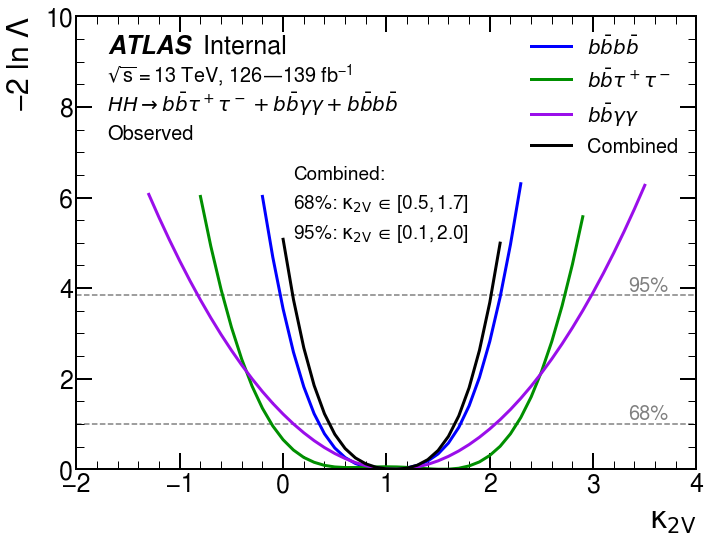

In [87]:
from IPython.display import display, HTML

# 1D
df_all = {}

for study in studies:
    if '_' in study and 'profile' not in study: continue
    df_all[study] = {}
    for o in obs:
        df_all[study][o] = []
        xlabel, xattrib, xrange, yrange = kappa_name_1D(study)
        if 'profile' in study:
            xattrib = xattrib.split('_')[0]
        for status in statuses:
            df = plot_1D(likelihood_df, study, o, xlabel=xlabel, xattrib=xattrib, xmin = xrange[0], xmax = xrange[1], ymin=yrange[0], ymax = yrange[1], status=status)
            break
        df_all[study][o].append(df)
        
for study in df_all:
    for o in df_all[study]:
        print(study, o)
        display(pd.concat(df_all[study][o]).T)

# styles_map_alter = {
#     'expected': {"color": 'k', "linestyle": '--', "marker": ","},
#     'observed': {"color": 'k', "linestyle": '-', "marker": ","},
# }        
# channel_label_map_alter = {
#     'expected': "Expected",
#     'observed': "Observed",
# }      
# for study in studies:
#     if study.endswith('_profile'):
#         study2 = study.split('_')[0]
#     else:
#         study2 = study
#     xlabel, xattrib, xrange, yrange = kappa_name_1D(study2)
#     plot_1D(likelihood_df_alter, study, 'combined', xlabel=xlabel, xattrib=xattrib, xmin = xrange[0], xmax = xrange[1], ymin=yrange[0], ymax = yrange[1])


In [88]:
import pandas as pd

studies = ['klambda', 'k2V'] #['k2V_kV_profile'] #
channels = ['bbtautau', 'bbyy', 'bbbb', 'combined']

for poi_str in studies:
    df_all = []
    for job in obs:
        for channel in channels:
            outpath = os.path.join(outdir_likelihood, "likelihood", job, channel, poi_str, 'cache', f'{poi_str}_uncond.json')
            with open(outpath) as fp:
                dic = json.load(fp)['uncond_fit']
            df = pd.DataFrame.from_dict(dic).drop(['status', 'time', 'nll'], axis=1)
            df.insert(0, 'channel', channel)
            df.insert(1, 'dataset', job)
            df_all.append(df)
    display(pd.concat(df_all))

,channel,dataset,muhat,muhat_errlo,muhat_errhi
klambda,bbtautau,expected,1.000007,-3.269761,3.269761
klambda,bbyy,expected,1.000074,-3.516757,3.516757
klambda,bbbb,expected,1.000000,-6.799684,6.799684
klambda,combined,expected,1.000004,-2.321669,2.321669
klambda,bbtautau,observed,1.509777,-3.536213,3.536213
klambda,bbyy,observed,2.753165,-2.131532,2.131532
klambda,bbbb,observed,6.180145,-3.749435,3.749435
klambda,combined,observed,3.086026,-2.106768,2.106768


,channel,dataset,muhat,muhat_errlo,muhat_errhi
k2V,bbtautau,expected,1.000056,-6.085540,6.085540
k2V,bbyy,expected,1.000124,-12.893607,12.893607
k2V,bbbb,expected,1.000000,-3.946275,3.946275
k2V,combined,expected,1.000023,-2.870616,2.870616
k2V,bbtautau,observed,1.547199,-1.149918,1.149918
k2V,bbyy,observed,1.077148,-0.978308,0.978308
k2V,bbbb,observed,1.016014,-1.042931,1.042931
k2V,combined,observed,1.072323,-0.821725,0.821725


### 3.2 2D klambda vs kt

In [29]:
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
from quickstats.utils.common_utils import combine_dict


In [30]:
styles = {
    'legend':{
        'loc': (0.05, 0.05),
        'fontsize': 18,
        },
    'xtick':{
        'format': 'numeric',
        'steps': [1, 10],
        'nbins': 20
        },
    'ytick':{
        'steps': [1,10],
        'nbins': 10
    }
}
analysis_label_options_default = {
    'status': 'int',
    'energy': '13 TeV',
    'lumi': '126—139 fb$^{-1}$',
    'fontsize': 30,
    'loc': (0.05, 0.95),
}

config = {
    'sm_values': (1,1),
    'sm_pos': 0.78,
    'sm_line_styles':{
        'color': 'gray',
        'linestyle': 'dashdot'
    }
}
            


In [220]:
def plot_kl_kt(study, obs, channel, show_colormesh=True, x='klambda', y='kt', xlabel=r"$\mathrm{\kappa_{\lambda}}$", ylabel=r"$\mathrm{\kappa_{t}}$", xmin=None, xmax=None, ymin=None, ymax=None):
    df_index = f'{study}_{obs}'
    df = likelihood_df[df_index][channel]
    if xmin is None:
        xmin = df[x].min()
    if xmax is None:
        xmax = df[x].max()
    if ymin is None:
        ymin = df[y].min()
    if ymax is None:
        ymax = df[y].max()
    df = df[(df[x]>=xmin) & (df[x]<=xmax) & (df[y]>=ymin) & (df[y]<=ymax)]

    plotter = Likelihood2DPlot(df, styles=styles, analysis_label_options=analysis_label_options_new(study, obs, channel))
    plotter.config = combine_dict(plotter.config, config)
    plotter.add_highlight(1, 1, label="SM prediction")
#     best_fit = uncond_df[f'{study}_{o}'][channel]['muhat']
#     best_fit_x = best_fit[x]
#     best_fit_y = best_fit[y]
    best_fit_x = uncond_df[f'{study}_{o}'][channel][x][0]
    best_fit_y = uncond_df[f'{study}_{o}'][channel][y][0]
    plotter.add_highlight(best_fit_x, best_fit_y, label=f"Best fit ({best_fit_x:.2f}, {best_fit_y:.2f})", styles={'marker': 'P', 'linewidth': 0, 'markersize': 15, })

    plotter.draw(xattrib=x, yattrib=y, xlabel=xlabel, ylabel=ylabel, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, draw_sm_line=True, show_colormesh=show_colormesh)

    savefolder = outdir_likelihood + '/figures/likelihood_scan'
    os.makedirs(savefolder, exist_ok=True)
    name = savefolder+f"/likelihood_scan_{channel}_{df_index}.pdf"
    if show_colormesh:
        name = savefolder+f"/likelihood_scan_{channel}_{df_index}_mesh.pdf"
    plt.savefig(name, bbox_inches="tight")
    print('Save', name)
    return df

Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220520_with_BR_decorrelation//figures/likelihood_scan/likelihood_scan_bbtautau_klambda_k2V_2D_expected_mesh.pdf


<Figure size 432x288 with 0 Axes>

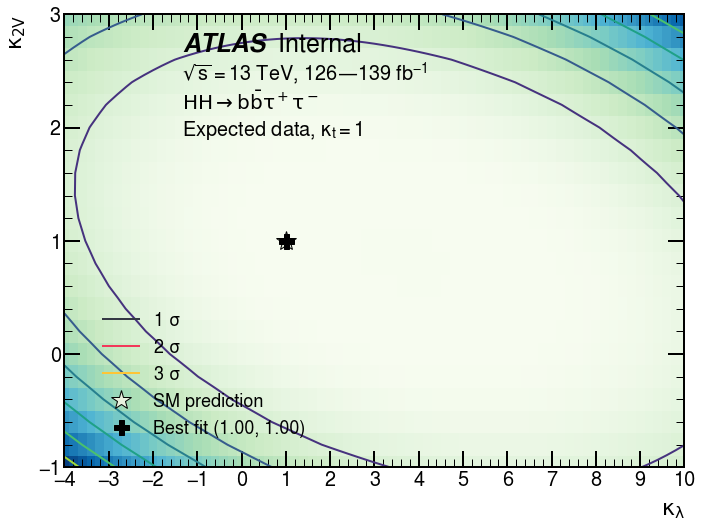

In [38]:
channels = ['bbbb', 'bbtautau', 'bbyy']
for channel in ['bbtautau']: #channels + ['combined']:
    for o in ['expected']: #obs:
        for study in studies:
            if '_2D' not in study: continue
            poi = study.split('_')
            _ = plot_kl_kt(study, o, channel, True, x=poi[0], y=poi[1], xlabel=kappa_name_1D(poi[0])[0], ylabel=kappa_name_1D(poi[1])[0])


## SM likelihood

In [46]:
def get_likelihood_scan():
    data = {}
    channel = 'combined'
    data[channel] = {}
    limit_path = os.path.join(outdir_xsection, 'likelihood_scan', 'xsec_br.json')
    try:
        data[channel] = json.load(open(limit_path))
    except:
        print(limit_path)
        raise
    return data
    
def data_load_likelihood():
    likelihood_df = {}
    uncond_df = {}
    data = get_likelihood_scan()
    for channel in data:
        df = pd.DataFrame(data[channel]).dropna(axis=1, how='all')
        df.rename(columns = {'xsec_br':'mu_HH'}, inplace = True)
        df_uncond = df.drop(index=df.index[1:], axis=0, inplace=False)
        df_scan = df.drop(index=df.index[0], axis=0, inplace=False)
#         df_scan = df_scan.drop(df_scan[df_scan['qmu']>cut].index)
        likelihood_df[channel] = df_scan
        uncond_df[channel] = df_uncond
    return likelihood_df, uncond_df

In [47]:
likelihood_df_SM, uncond_df_SM = data_load_likelihood()

             nll  qmu     mu_HH        mu
0  756924.403172  0.0 -0.732936 -0.732936


In [61]:
likelihood_df_SM['combined']

,nll,qmu,mu_HH,mu
1,NaN,NaN,-3.0,-3.0
2,NaN,NaN,-2.8,-2.8
3,NaN,NaN,-2.6,-2.6
4,756936.193480,23.580615,-2.4,-2.4
5,756925.026897,1.247450,-2.2,-2.2
6,756924.883910,0.961475,-2.0,-2.0
7,756924.753963,0.701582,-1.8,-1.8
8,756924.639628,0.472912,-1.6,-1.6
9,756924.544790,0.283236,-1.4,-1.4
10,756924.485769,0.165193,-1.2,-1.2


In [58]:
from quickstats.maths.numerics import is_integer, pretty_value

def plot_1D(likelihood_df, xmin = -5, xmax = 5, ymin=0, ymax = 12, xlabel=r"$\mu_{HH}$", xattrib='mu_HH', yattrib='qmu', status='int'):
    options = {}
    config = {
        'sigma_values': (1, 3.84),
        'sigma_levels': ('1sigma', '0.95'),
        'sigma_names': ('68%', '95%'),
        'sigma_pos': 0.89,
     }
    name = 'likelihood_scan'
    if yattrib == 'qmu' and ymax < 4:
        options['draw_sigma_line'] = False
        name += '_zoom'
    
    plotter = Likelihood1DPlot(likelihood_df, 
                              config = config)
    ax = plotter.draw(xlabel=xlabel, ylabel="$-2\ ln\ \Lambda$", ymin=ymin, ymax=ymax, xmin=xmin, xmax=xmax, xattrib=xattrib, yattrib=yattrib, **options)


<Figure size 432x288 with 0 Axes>

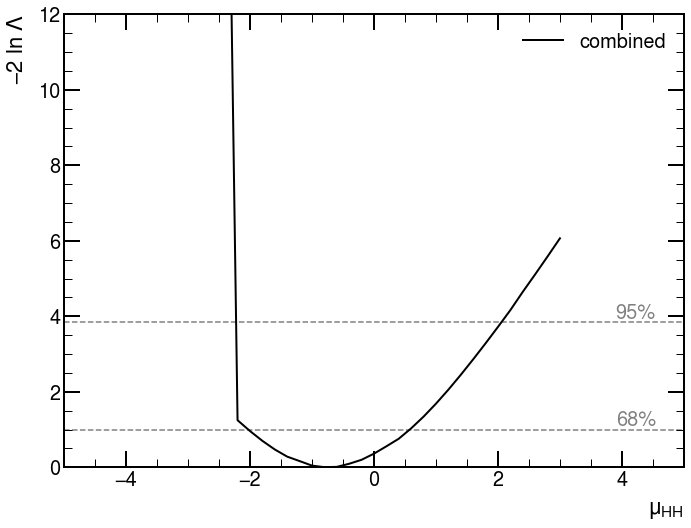

In [59]:
plot_1D(likelihood_df_SM)

In [212]:
## debug likelihood

In [232]:
def get_likelihood(limit_paths, names):
    data = {}
    for limit_path, name in zip(limit_paths, names):
        limit_path = os.path.join(limit_path)
        try:
            data[name] = json.load(open(limit_path))
        except:
            print(limit_path)
            raise
    return data
    
def data_loading_lh():
    likelihood_df = {}
    
    limit_paths = [
        '/afs/cern.ch/user/z/zhangr/bbyytest/likelihood/klambda.json',
        '/afs/cern.ch/user/z/zhangr/bbyytest/likelihood_kl/klambda.json',
        '/afs/cern.ch/user/z/zhangr/bbyytest/likelihood_fitted/klambda.json',
        '/afs/cern.ch/user/z/zhangr/bbyytest/elena/LikelihoodScan_klambda_h026_bbyy_param_EWcorr_mu_unblind_syst_combData.json',
    ]
    names = [
        'bbyy',
        'bbtautau',
        'bbbb',
        'combined'
    ]
    data = get_likelihood(limit_paths, names)
    for name in names:
        df = pd.DataFrame(data[name]).dropna(axis=0, how='any')
        likelihood_df[name] = df
    return likelihood_df



from quickstats.maths.numerics import is_integer, pretty_value
import pandas
from quickstats.maths.interpolation import get_intersections

def get_interval(df, level):
    xvalues = df['klambda'].to_numpy()
    yvalues = df['qmu'].to_numpy()
    func_theory = interp1d(xvalues, yvalues)
    try:
        x_new = np.arange(min(xvalues), max(xvalues), 0.01)
        y_new = func_theory(x_new)
    except:
        set_trace()
    
    asign = np.sign(y_new-level)
    signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
    intersections = x_new[signchange==1]
    return intersections


def plot_1Ddebug(likelihood_df, xmin = -15, xmax = 20, ymin=0, ymax = 12, xlabel=r"$\mathrm{\kappa_{\lambda}}$", xattrib='klambda', yattrib='qmu', status='int'):
    dic = {}
    options = {}
    config = {
        'sigma_values': (1, 3.84),
        'sigma_levels': ('1sigma', '0.95'),
        'sigma_names': ('68%', '95%'),
        'sigma_pos': 0.89,
     }
    name = 'likelihood_scan'
    if yattrib == 'kt':
        options['ylabel'] = r"Best fit $\mathrm{\kappa_{t}}$"
        options['draw_sigma_line'] = False
        name = yattrib
    if yattrib == 'qmu' and ymax < 4:
        options['draw_sigma_line'] = False
        name += '_zoom'
    plotter = Likelihood1DPlot(likelihood_df, label_map=channel_label_map if obs != 'combined' else channel_label_map_alter, styles_map=styles_map if obs != 'combined' else styles_map_alter,
                            styles=styles[study], analysis_label_options=analysis_label_options_new(study, obs, status=status),
                              config = config)
    ax = plotter.draw(xlabel=xlabel, ylabel="$-2\ ln\ \Lambda$", ymin=ymin, ymax=ymax, xmin=xmin, xmax=xmax, xattrib=xattrib, yattrib=yattrib, **options)
#     set_trace()
#     if 'combined' in likelihood_df and yattrib=='qmu':
#         dic['combined'] = {}
#         intersections_1 = get_interval(likelihood_df['combined'], 1).tolist()
#         intersections_2 = get_interval(likelihood_df['combined'], 3.84).tolist()
#         dic['combined']['1sigma low'] = intersections_1[0]
#         dic['combined']['1sigma high'] = intersections_1[1]
#         dic['combined']['95% low'] = intersections_2[0]
#         dic['combined']['95% high'] = intersections_2[1]

#         ax.annotate(r'Combined:', 
#                     (anno_op[study]['x'], anno_op[study]['y']), xycoords = 'axes fraction', fontsize = anno_op[study]['font_size'])
#         ax.annotate(r'$68\%$: '+xlabel+r'$ \in [%.1f, %.1f]$' %(intersections_1[0], intersections_1[1]), 
#                     (anno_op[study]['x'], anno_op[study]['y'] - anno_op[study]['dy']), xycoords = 'axes fraction', fontsize = anno_op[study]['font_size'])
#         ax.annotate(r'$95\%$: '+xlabel+r'$ \in [%.1f, %.1f]$' %(intersections_2[0], intersections_2[1]), 
#                     (anno_op[study]['x'], anno_op[study]['y'] - 2 * anno_op[study]['dy']), xycoords = 'axes fraction', fontsize = anno_op[study]['font_size'])


    for c in ['bbyy', 'bbtautau', 'bbbb', 'combined']:
        if c not in dic:
            dic[c] = {}

        intersections_1 = get_interval(likelihood_df[c], 1).tolist()
        intersections_2 = get_interval(likelihood_df[c], 3.84).tolist()
        intersections_1p = get_intersections(likelihood_df[c]['klambda'].values, likelihood_df[c]['qmu'].values, level=1, delta=0.0001)
        intersections_2p = get_intersections(likelihood_df[c]['klambda'].values, likelihood_df[c]['qmu'].values, level=4, delta=0.0001)

        dic[c]['1sigma low'] = intersections_1[0]
        dic[c]['1sigma high'] = intersections_1[1]
        dic[c]['95% low'] = intersections_2[0]
        dic[c]['95% high'] = intersections_2[1]
#         print( c, '1sigma:', [i for i in intersections_1], '95%:', [pretty_value(i) for i in intersections_2])
        print('alkaid', c, '1sigma:', [pretty_value(i) for i in intersections_1p], '2sigma:', [pretty_value(i) for i in intersections_2p])
        
    df = pandas.DataFrame.from_dict(dic)
    return df

In [233]:
df = data_loading_lh()

alkaid bbyy 1sigma: [array([0.57, 4.76])] 2sigma: [array([-1.51,  6.54])]
alkaid bbtautau 1sigma: [array([0.57, 4.76])] 2sigma: [array([-1.51,  6.54])]
alkaid bbbb 1sigma: [array([0.57, 4.76])] 2sigma: [array([-1.51,  6.54])]
alkaid combined 1sigma: [array([0.57, 4.76])] 2sigma: [array([-1.51,  6.54])]


<Figure size 432x288 with 0 Axes>

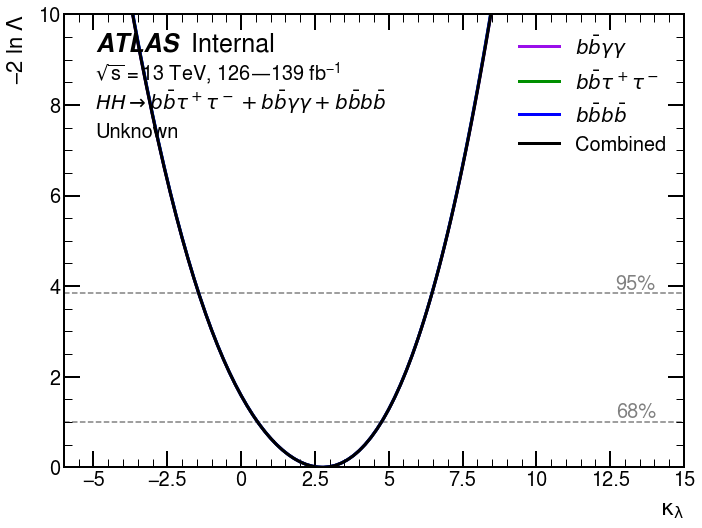

In [234]:
df_table = plot_1Ddebug(df, xlabel=xlabel, xattrib=xattrib, xmin = xrange[0], xmax = xrange[1], ymin=yrange[0], ymax = yrange[1], status=status)

bbyy 1sigma: [0.57, 4.76] 95%: [-1.43, 6.47]
alkaid bbyy 1sigma: [array([0.57, 4.76])] 95%: [array([-1.51,  6.54])]
bbtautau 1sigma: [0.57, 4.76] 95%: [-1.43, 6.47]
alkaid bbtautau 1sigma: [array([0.57, 4.76])] 95%: [array([-1.51,  6.54])]
bbbb 1sigma: [0.57, 4.76] 95%: [-1.43, 6.47]
alkaid bbbb 1sigma: [array([0.57, 4.76])] 95%: [array([-1.51,  6.54])]
combined 1sigma: [0.57, 4.76] 95%: [-1.43, 6.47]
alkaid combined 1sigma: [array([0.57, 4.76])] 95%: [array([-1.51,  6.54])]


<Figure size 432x288 with 0 Axes>

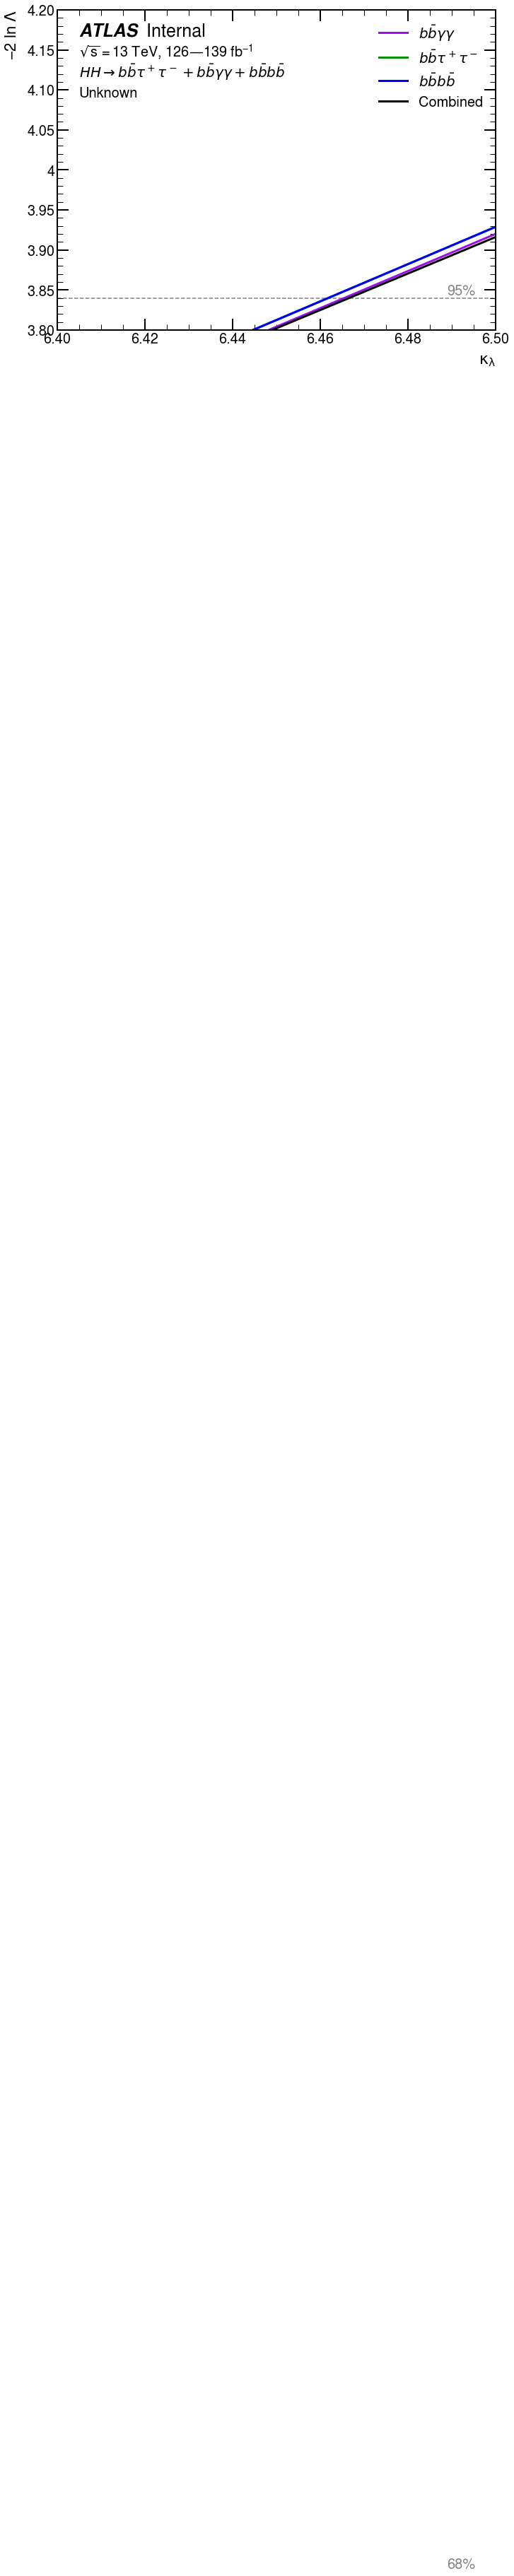

In [198]:
df_table = plot_1Ddebug(df, xlabel=xlabel, xattrib=xattrib, xmin = 6.4, xmax = 6.5, ymin=3.8, ymax = 4.2, status=status)

bbyy 1sigma: [0.57, 4.76] 95%: [-1.43, 6.47]
alkaid bbyy 1sigma: [array([0.57, 4.76])] 95%: [array([-1.51,  6.54])]
bbtautau 1sigma: [0.57, 4.76] 95%: [-1.43, 6.47]
alkaid bbtautau 1sigma: [array([0.57, 4.76])] 95%: [array([-1.51,  6.54])]
combined 1sigma: [0.57, 4.76] 95%: [-1.43, 6.47]
alkaid combined 1sigma: [array([0.57, 4.76])] 95%: [array([-1.51,  6.54])]


<Figure size 432x288 with 0 Axes>

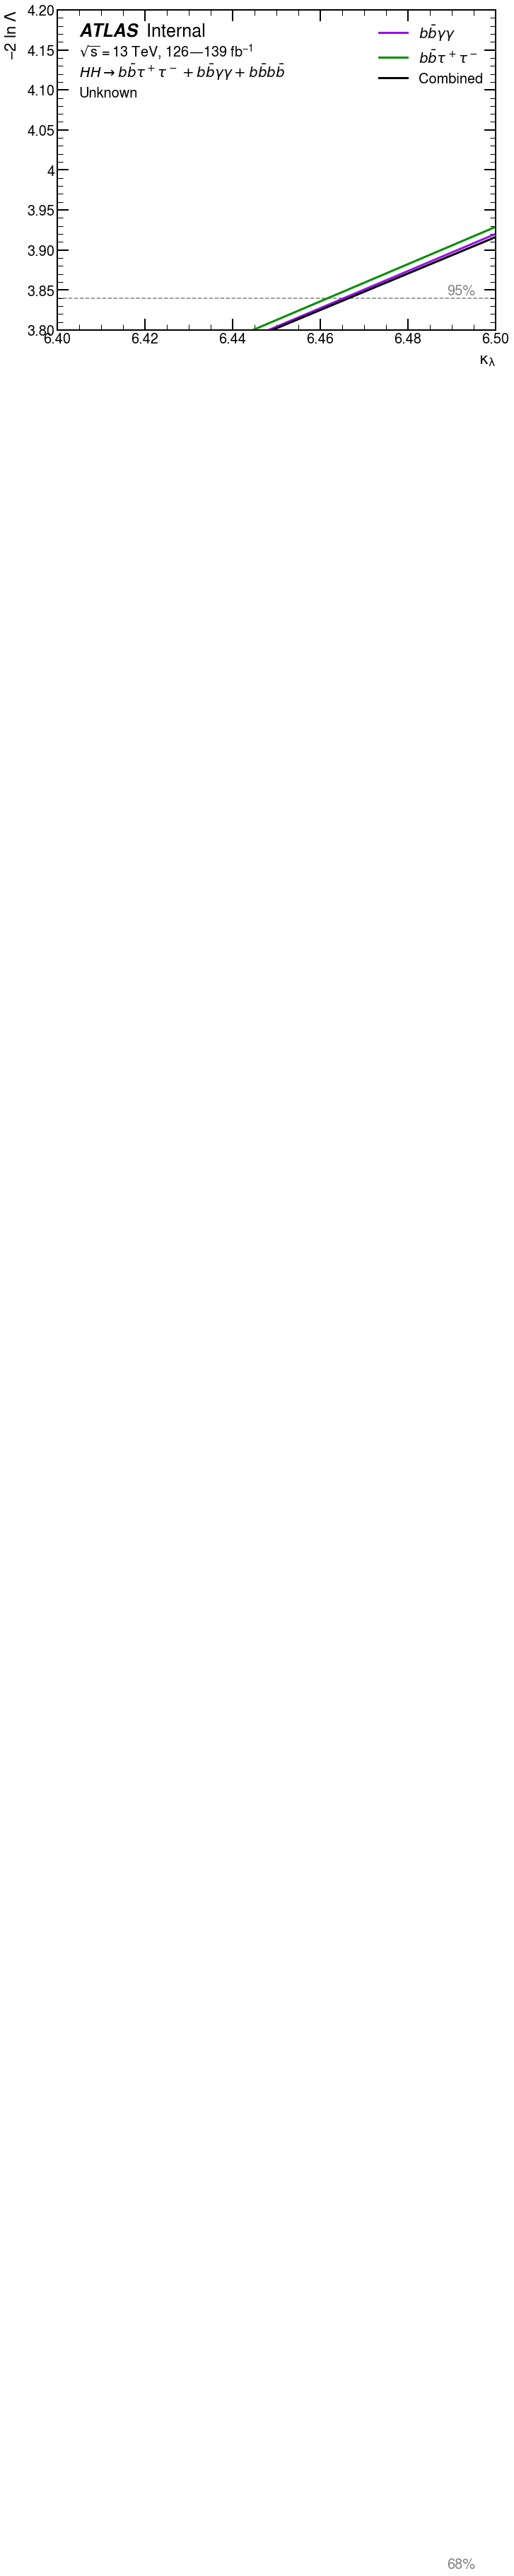

In [205]:
df_table = plot_1Ddebug(df, xlabel=xlabel, xattrib=xattrib, xmin = 6.4, xmax = 6.5, ymin=3.8, ymax = 4.2, status=status)

In [188]:
df['combined'][(df['combined']['klambda'] > 6.3) &(df['combined']['klambda'] <6.7)]

,nll,qmu,klambda
165,519.754039,3.688033,6.4
166,519.868038,3.916032,6.5
167,519.985939,4.151834,6.6


(0.999, 1.001)

<Figure size 432x288 with 0 Axes>

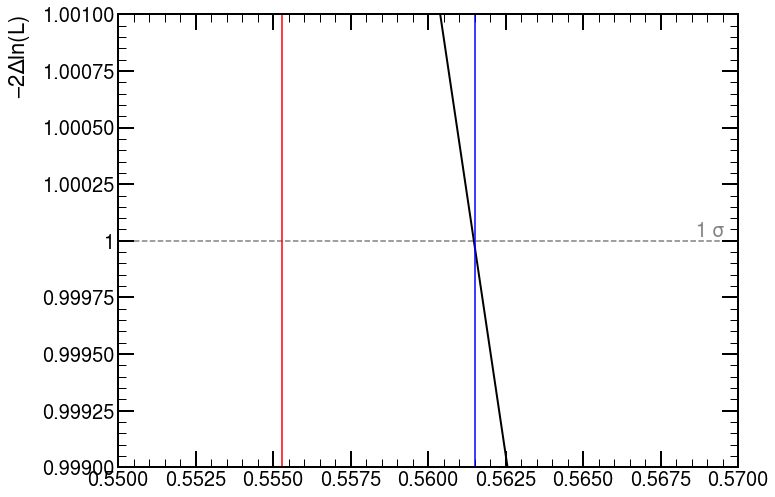

In [222]:
from quickstats.maths.interpolation import get_intersections
fname = "/afs/cern.ch/user/z/zhangr/bbyytest/elena/LikelihoodScan_klambda_h026_bbyy_param_EWcorr_mu_unblind_syst_combData.json"
with open(fname) as fp:
    data = json.load(fp)
df = pd.DataFrame(data).dropna()
intersections = get_intersections(df["klambda"].values, df["qmu"].values, level=1, delta=0.0001)
from quickstats.plots import Likelihood1DPlot
plotter = Likelihood1DPlot(df)
plotter.config['sigma_values'] = (1,)
plotter.config['sigma_names'] = [r'1 $\sigma$']
ax = plotter.draw(xattrib="klambda", xmin=0.55, xmax=0.57)
ax.axvline(intersections[0][0], color="b")
ax.axvline(intersections[0][1], color="b")
ax.axvline(0.55527764, color="r")
ax.axvline(4.74737369, color="r")
ax.set_ylim((0.999, 1.001))